# Reproducing the Gridworld Example

This notebook reproduces the Gridworld example from the "Methods of Machine Learning" course (Summer 2025).

Our goal is to replicate the results from **Page 16** (Policy Evaluation) and **Page 20** (Optimal Policy) of the lecture slides (`MeML_V04.pdf`).

We will use `numpy` for our calculations.

## Defining the Gridworld Environment

First, we must define the dynamics of the Gridworld based on the slides.

* **States ($S$)**: A 4x4 grid, so 16 states, numbered 0-15.
* **Terminal States**: States 0 (top-left) and 15 (bottom-right) are terminal. Their value is always 0.
* **Actions ($A$)**: 4 actions: North, South, East, West. We'll map them to `0, 1, 2, 3`.
* **Rewards ($R$)**: We define the reward function as $R(s, a, s') = -1$ for every transition taken from a non-terminal state. The terminal states (0 and 15) are absorbing states where the episode ends; therefore, they represent a future expected return (Value) of 0.
* **Discount Factor ($\gamma$)**: The task is episodic, and the values (average number of moves) suggest a discount factor $\gamma = 1.0$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Grid dimensions
GRID_ROWS = 4
GRID_COLS = 4
STATES = GRID_ROWS * GRID_COLS

# Terminal states
TERMINAL_STATES = [0, 15]

# Actions: 0=North, 1=South, 2=East, 3=West
ACTIONS = [0, 1, 2, 3]

# Rewards
STEP_REWARD = -1.0
TERMINAL_REWARD = 0.0

# Discount factor
GAMMA = 1.0

print(f"Grid: {GRID_ROWS}x{GRID_COLS} ({STATES} states)")
print(f"Terminal States: {TERMINAL_STATES}")

Grid: 4x4 (16 states)
Terminal States: [0, 15]


## Transition Function

The step function below is the transition function. Given a state s and an action a, it deterministically outputs the next state s', and the reward that comes with arriving at state s'.

In [2]:
def step(state, action):
    """
    Calculates the next state and reward given a current state and action.
    """
    if state in TERMINAL_STATES:
        # If we are already in a terminal state, no action, no reward.
        return state, TERMINAL_REWARD
    
    row = state // GRID_COLS
    col = state % GRID_COLS

    # Apply the action
    if action == 0:  # North
        row = max(row - 1, 0)
    elif action == 1:  # South
        row = min(row + 1, GRID_ROWS - 1)
    elif action == 2:  # East
        col = min(col + 1, GRID_COLS - 1)
    elif action == 3:  # West
        col = max(col - 1, 0)
        
    next_state = row * GRID_COLS + col
    
    # The reward is ALWAYS -1.0 for any action taken from a non-terminal state.
    reward = STEP_REWARD 
        
    return next_state, reward

print(f"From state 5 (row 1, col 1), action 'North' (0) -> {step(5, 0)}")
print(f"From state 4 (row 1, col 0), action 'West' (3) -> {step(4, 3)}") # Hit wall
print(f"From state 1 (row 0, col 1), action 'West' (3) -> {step(1, 3)}") # To terminal (state 0)

From state 5 (row 1, col 1), action 'North' (0) -> (1, -1.0)
From state 4 (row 1, col 0), action 'West' (3) -> (4, -1.0)
From state 1 (row 0, col 1), action 'West' (3) -> (0, -1.0)


## Policy Evaluation (Slide 16)

Our first task is to evaluate the **uniform random policy**, where every action is chosen with equal probability $\pi(a|s) = 1/4 = 0.25$.

We need to find the value function $v_\pi(s)$ for this policy. We will solve the Bellman equation in its linear system form:

$$(I - \gamma P_\pi) v_\pi = b_\pi$$

Where:
* $v_\pi$ is the 16x1 vector of state values we want to find.
* $I$ is the 16x16 identity matrix.
* $P_\pi$ is the 16x16 state-transition matrix under policy $\pi$, $P_\pi[s, s'] = \sum_a \pi(a|s) p(s'|s,a)$.
* $b_\pi$ is the 16x1 vector of expected one-step rewards, $b_\pi[s] = \mathbb{E}_\pi[R_{t+1} | S_t = s]$.

We will build the matrix $A = (I - \gamma P_\pi)$ and the vector $b = b_\pi$, then use `np.linalg.solve(A, b)` to find $v_\pi$.


In [3]:
def evaluate_policy_linear_system(policy_prob=0.25):
    """
    Computes v_pi using Matrix operations: v = (I - gamma * P)^-1 * b
    """
    # Initialize P_pi (Transition Matrix) and b_pi (Expected Reward Vector)
    P_pi = np.zeros((STATES, STATES))
    b_pi = np.zeros(STATES)

    for s in range(STATES):
        if s in TERMINAL_STATES:
            # Terminal states have value 0. 
            # Because we initialized I = np.eye(STATES) and left P_pi[s,:] as 0,
            # the equation for this state becomes: 1*v(s) - 0 = 0 -> v(s)=0.
            # This implicitly enforces the boundary condition.
            continue

        for a in ACTIONS:
            next_s, r = step(s, a)

            # Update Transition Matrix P_p[s, s']
            # We add probability because multiple actions might lead to same state
            P_pi[s, next_s] += 0.25

            # Update Expected Reward Vector b_pi[s]
            # b[s] = sum(prob(a|s) * reward(s,a))
            b_pi[s] += policy_prob * r

    # Construct the Linear System: (I - gamma * P_pi) * v = b_pi
    I = np.eye(STATES)
    A = I - (GAMMA * P_pi)

    # Solve for v_pi
    v_pi = np.linalg.solve(A, b_pi)

    return v_pi

# --- Run Policy Evaluation ---
v_pi_random = evaluate_policy_linear_system()

print("--- Value Function v_pi (Random Policy) ---")
print(np.round(v_pi_random.reshape(GRID_ROWS, GRID_COLS), 1))

--- Value Function v_pi (Random Policy) ---
[[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]


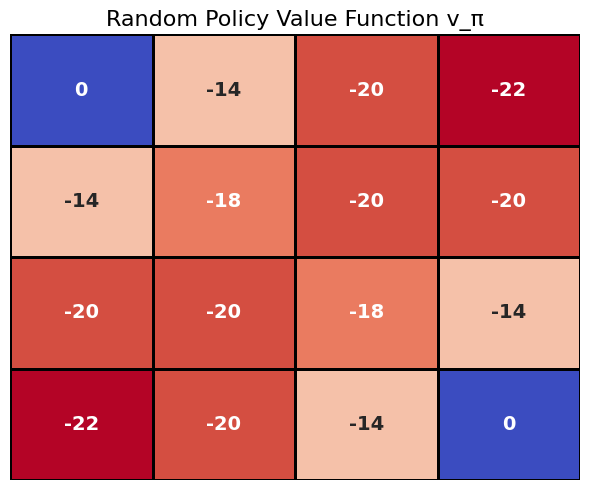

In [4]:
def plot_value_function(v_vec, title="Value Function"):
    v_grid = v_vec.reshape(GRID_ROWS, GRID_COLS)
    
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(v_grid, annot=True, fmt="g", cmap="coolwarm_r", 
                     cbar=False, linewidths=1, linecolor='black',
                     annot_kws={"size": 14, "weight": "bold"})
    
    plt.title(title, fontsize=16)
    plt.xticks([]) 
    plt.yticks([])
    plt.tight_layout()
    plt.show()

# Generate plot for Slide 16 content
plot_value_function(v_pi_random, title="Random Policy Value Function v_π")

## Optimal Policy & Value Function (Slide 20)

Now, we want to find the **optimal** value function, $v^*$, and the **optimal** policy, $\pi^*$.

This requires solving the **Bellman Optimality Equation**:

$$v^*(s) = \max_{a \in \mathcal{A}}\left(\overline{r}(s,a) + \gamma \sum_{s'} \overline{p}(s'|s,a) v^*(s')\right)$$

This equation is non-linear because of the $\max$ operator, so we can't solve it as a simple linear system. Instead, we use **Value Iteration** as described in the slides.

This is an iterative algorithm that repeatedly updates the value function using the Bellman Optimality Equation as an update rule until it converges.

In [5]:
def run_value_iteration(threshold=1e-6):
    """Calculates the optimal value function v* using Value Iteration."""
    
    # Initialize v(s) = 0 for all states (our initial "guess")
    v_star = np.zeros(STATES)
    
    while True:
            delta = 0  # Track max change
            
            # Create a copy of the current values. 
            # We read from v_old (iteration k) and write to v_star (iteration k+1).
            v_old = v_star.copy() 
            
            for s in range(STATES):
                if s in TERMINAL_STATES:
                    continue
                    
                action_values = []
                for a in ACTIONS:
                    next_s, reward = step(s, a)
                    
                    # CRITICAL CHANGE: Use v_old[next_s] instead of v_star[next_s]
                    # This ensures synchronous updates: v_{k+1} is based entirely on v_k.
                    action_values.append(reward + GAMMA * v_old[next_s])
                
                best_value = np.max(action_values)
                
                # Calculate delta using the difference from the old value
                delta = max(delta, abs(best_value - v_old[s]))
                
                # Update the state's value in the "new" array
                v_star[s] = best_value
            
            if delta < threshold:
                break            
    return v_star

# --- Run Value Iteration ---
v_star = run_value_iteration()

print("--- Optimal Value Function v* ---")
print(np.round(v_star.reshape(GRID_ROWS, GRID_COLS), 0))

--- Optimal Value Function v* ---
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]


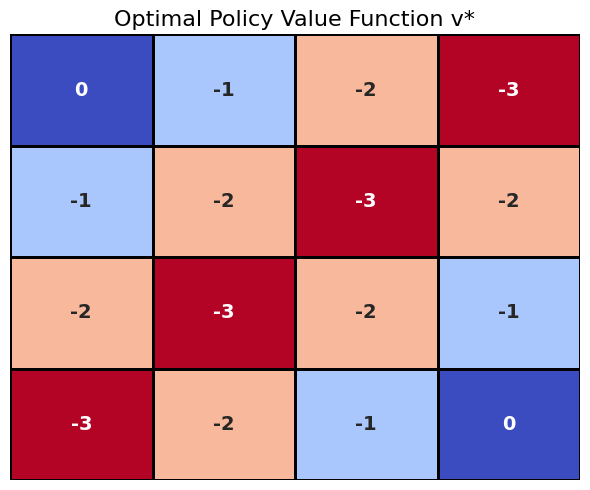

In [6]:
plot_value_function(v_star, title="Optimal Policy Value Function v*")

## Extracting the Optimal Policy $\pi^*$

Finally, once we have $v^*$, we can find the optimal policy $\pi^*$. The optimal policy is to simply be "greedy" with respect to $v^*$. In any state $s$, choose the action $a$ that maximizes the expected return:

$$ \pi^*(s) = \arg\max_{a \in \mathcal{A}} \left(\overline{r}(s,a) + \gamma \sum_{s'} \overline{p}(s'|s,a) v^*(s')\right) $$

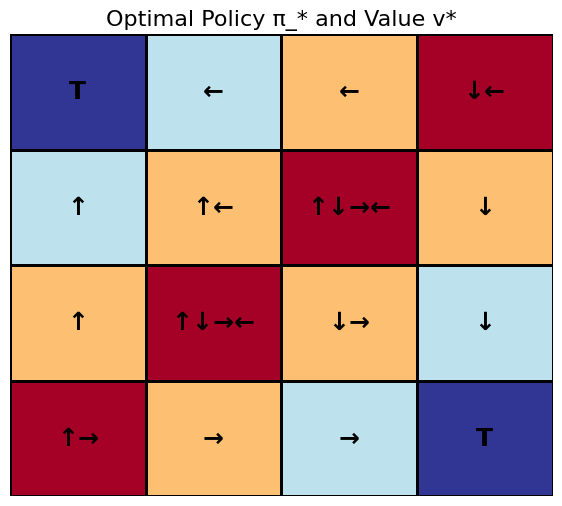

In [7]:
def plot_optimal_policy_heatmap(v_star):
    # Reshape v_star for the heatmap
    v_grid = v_star.reshape(GRID_ROWS, GRID_COLS)
    
    # Symbols for arrows: 0=N, 1=S, 2=E, 3=W
    arrows = {0: '↑', 1: '↓', 2: '→', 3: '←'}
    
    plt.figure(figsize=(7, 6))
    
    # Create the Heatmap
    ax = sns.heatmap(v_grid, annot=False, cmap="RdYlBu", 
                     cbar=False, linewidths=1, linecolor='black')
    
    # Loop over every state to place the text (Arrows or T)
    for s in range(STATES):
        row, col = divmod(s, GRID_COLS)
        
        if s in TERMINAL_STATES:
            text = "T"
        else:
            # Find the Greedy Action(s)
            best_val = -float('inf')
            best_actions = []
            for a in ACTIONS:
                next_s, r = step(s, a)
                val = r + GAMMA * v_star[next_s]
                
                # Use isclose to handle floating point ties
                if val > best_val and not np.isclose(val, best_val):
                    best_val = val
                    best_actions = [a]
                elif np.isclose(val, best_val):
                    best_actions.append(a)
            
            # Combine arrows if multiple actions are optimal (e.g., "↑←")
            text = "".join([arrows[a] for a in best_actions])
            
        # Place text in the center of the cell
        plt.text(col + 0.5, row + 0.5, text, 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=18, weight='bold', color='black')

    plt.title("Optimal Policy π_* and Value v*", fontsize=16)
    plt.axis('off') # Hide x/y axis ticks for a cleaner look
    plt.show()

plot_optimal_policy_heatmap(v_star)

## Conclusion

We have successfully reproduced the key results from the Gridworld example.
1.  We calculated $v_\pi$ for the random policy (Page 16) by solving the Bellman linear system $(I - \gamma P_\pi) v_\pi = b_\pi$.
2.  We calculated the optimal $v^*$ (Page 20) using Value Iteration to solve the Bellman Optimality Equation.
3.  We extracted the optimal policy $\pi^*$ (Page 20) by finding the greedy actions with respect to $v^*$.